# Run this notebook to evaluate the pre-trained models

## Import statements

In [1]:
!pip install torchmetrics
!pip install torch-fidelity

In [20]:
import os
import torch
import torch.nn as nn
import gdown
import zipfile
import shutil
import pandas as pd
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
from IPython.display import Image as Img


root = '/content'
os.chdir(root)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Generator and Discriminator models

In [3]:
class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        # Input: X x z_dim x 1 x 1
        self._block(z_dim, features_g * 16, 4, 1, 0), # N x f_g*32 x 4 x 4
        self._block(features_g * 16, features_g * 8, 4, 2, 1), # 8 x 8
        self._block(features_g * 8, features_g * 4, 4, 2, 1), # 16 x 16
        self._block(features_g * 4, features_g * 2, 4, 2, 1), # 32 x 32
        self._block(features_g * 2, features_g, 4, 2, 1), # 64 x 64
        nn.ConvTranspose2d(
            features_g, channels_img, kernel_size=4, stride=2, padding=1,
        ),
        nn.Tanh(), # images are normalized to be within [-1, 1]
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
          in_channels,
          out_channels,
          kernel_size,
          stride,
          padding,
          bias=False,),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.gen(x)


class Discriminator(nn.Module):
  def __init__(self, channels_img, features_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # Input image: N x channels_img x 128 x 128
        nn.Conv2d(
            channels_img, features_d, kernel_size=4, stride=2, padding=1
        ), # 64 x 64
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d * 2, 4, 2, 1), # 32 x 32
        self._block(features_d * 2, features_d * 4, 4, 2, 1), # 16 x 16
        self._block(features_d * 4, features_d * 8, 4, 2, 1), # 8 x 8
        self._block(features_d * 8, features_d * 16, 4, 2, 1), # 4 x 4
        nn.Conv2d(features_d * 16, 1, kernel_size=4, stride=2, padding=0), # 1 x 1
            # single value representing if the image if fake or real
        nn.Sigmoid(),
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        #nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)


def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

## Load in data

In [4]:
#change this to specific animal or 'all' for all
datasets_list = ['dog', 'cat', 'horse', 'elephant', 'lion']


#download the data off of google drive
path_root = 'data/'

url = 'https://drive.google.com/file/d/1cEKacsYA7e6sZp-g3P5AwMVn6EdssFdd/view?usp=drive_link'
name = os.path.join(path_root, 'animal_dataset.zip')
process_folder_path = os.path.join(path_root, 'animals_processed')

#make the data folder
if not os.path.exists(path_root):
  os.makedirs(path_root)


#download the .zip file if not already downloaded
if not os.path.exists(name):
  gdown.download(url, name, fuzzy=True)

unprocessed_path = os.path.join(path_root, 'animals')
#unzip if the files if not already unzipped
if not os.path.exists(unprocessed_path):
  with zipfile.ZipFile(name, 'r') as ziphandler:
    ziphandler.extractall(path_root)

#wrap the folder in another folder so that the dataset loader works
for dataset in datasets_list:
  for i in range(2):
    name = 'train' if i == 0 else 'val'
    if dataset != "all":
      path_to_move = os.path.join(unprocessed_path, name, dataset)
      unproc_path = os.path.join(unprocessed_path, name, f'{dataset}_use')
      if not os.path.exists(unproc_path):
        os.makedirs(unproc_path)
        dest = shutil.move(path_to_move, unproc_path)


## Load in trained models for all animals

In [6]:
cat_url = 'https://drive.google.com/file/d/1fabotX8oOzMbiU3UVMXDj7THzfgNPd6K/view?usp=drive_link'
dog_url = 'https://drive.google.com/file/d/1RObpRz3w5wiLmOZKaOCbdbiKNqWUbP4k/view?usp=drive_link'
horse_url = 'https://drive.google.com/file/d/1rdy7YnYcNBSB0X-v4Q9RBalcrsvU7Xg4/view?usp=drive_link'
elephant_url = 'https://drive.google.com/file/d/1ILZ5WYuX-S6XvQV5wq0vU3eFWbboqR5i/view?usp=drive_link'
lion_url = 'https://drive.google.com/file/d/1rdy7YnYcNBSB0X-v4Q9RBalcrsvU7Xg4/view?usp=sharing'

model_path_root = 'models/'
if not os.path.exists(model_path_root):
  os.makedirs(model_path_root)

for dataset in datasets_list:
  if dataset == 'cat':
    url = cat_url
  elif dataset == 'dog':
    url = dog_url
  elif dataset == 'horse':
    url = horse_url
  elif dataset == 'elephant':
    url = elephant_url
  else:
    url = lion_url

  model_name = os.path.join(model_path_root, f'{dataset}_model.pth')
  if not os.path.exists(model_name):
    gdown.download(url, model_name, fuzzy=True)


## Evaluate using both FID and KID Metrics and Visualize the Latent Space

In [7]:
BATCH_SIZE = 100
IMAGE_SIZE = 128
CHANNELS_IMG = 3
Z_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64

def visualize_latent(generator, n_times, n_steps, device):
    latent_images = []
    for _ in range(n_times):
        z1 = torch.randn(1, Z_DIM, 1, 1).to(device)
        z2 = torch.randn(1, Z_DIM, 1, 1).to(device)

        interpolated_latents = torch.linspace(0, 1, steps=n_steps+2, device=device).view(-1, 1, 1, 1) * z1 + \
                                    (1 - torch.linspace(0, 1, steps=n_steps+2, device=device).view(-1, 1, 1, 1)) * z2
        with torch.no_grad():
            fake_images = generator(interpolated_latents)

        latent_images.extend(fake_images)
    comparison = torch.stack(latent_images)

    return comparison

def load_model(path, device):
    state_dict = torch.load(path, map_location=device)
    model = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
    model.load_state_dict(state_dict)
    model.eval()
    return model



def eval_kid(model, real, device):
    metric = KernelInceptionDistance(subset_size = 50).to(device)
    noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device) #generates random noise
    fake = model(noise) #creates the fake images
    fake = fake.to(dtype=torch.uint8)
    real = real.to(dtype=torch.uint8)
    metric.update(fake, False)
    metric.update(real, True)
    return metric.compute()

def eval_fid(model, real, device):
    metric = FrechetInceptionDistance().to(device)
    noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device) #generates random noise
    fake = model(noise) #creates the fake images
    fake = fake.to(dtype=torch.uint8)
    real = real.to(dtype=torch.uint8)
    metric.update(fake, False)
    metric.update(real, True)
    return metric.compute()


def run_eval(model, val_loader, device, fid=True):
  metric = 0
  kid_mean = 0
  kid_std = 0
  for batch_idx, (real, _) in enumerate(val_loader):
    real = real.to(device)
    if fid:
      metric += (eval_fid(model, real, device))
    else:
       mean, std = eval_kid(model, real, device)
       kid_mean += mean
       kid_std += std
  if not fid:
    metric = [kid_mean, kid_std]
  return metric

In [17]:
metrics = pd.DataFrame(columns = ['FID', 'KID mean', 'KID std'], index = datasets_list)

for dataset in datasets_list:
  path = f'models/{dataset}_model.pth'
  trained_model = load_model(path, device)

  transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
        #transforms.Grayscale(num_output_channels=CHANNELS_IMG)
  ])

  animal_path_train = os.path.join(unprocessed_path,'train', f'{dataset}_use')
  animal_path_val = os.path.join(unprocessed_path, 'val', f'{dataset}_use')
  train_dataset = datasets.ImageFolder(root=animal_path_train,
                                transform=transform)
  val_dataset = datasets.ImageFolder(root=animal_path_val, transform = transform)
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
  fid = run_eval(trained_model, val_loader, device, fid=True).item()
  kid = run_eval(trained_model, val_loader, device, fid=False)
  metrics.loc[dataset] = [round(fid / 3, 3), round(kid[0].item(), 3), round(kid[1].item(), 3)]

<ipython-input-7-68c5843e7567>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)
/usr/local/lib/python3.10/dist-packages/t

In [18]:
metrics

FID KID mean KID std
dog       89.075    0.128   0.032
cat        56.08    0.064    0.02
horse     43.635    0.042   0.015
elephant  56.166    0.052   0.018
lion      79.602    0.102   0.028

<ipython-input-7-68c5843e7567>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)


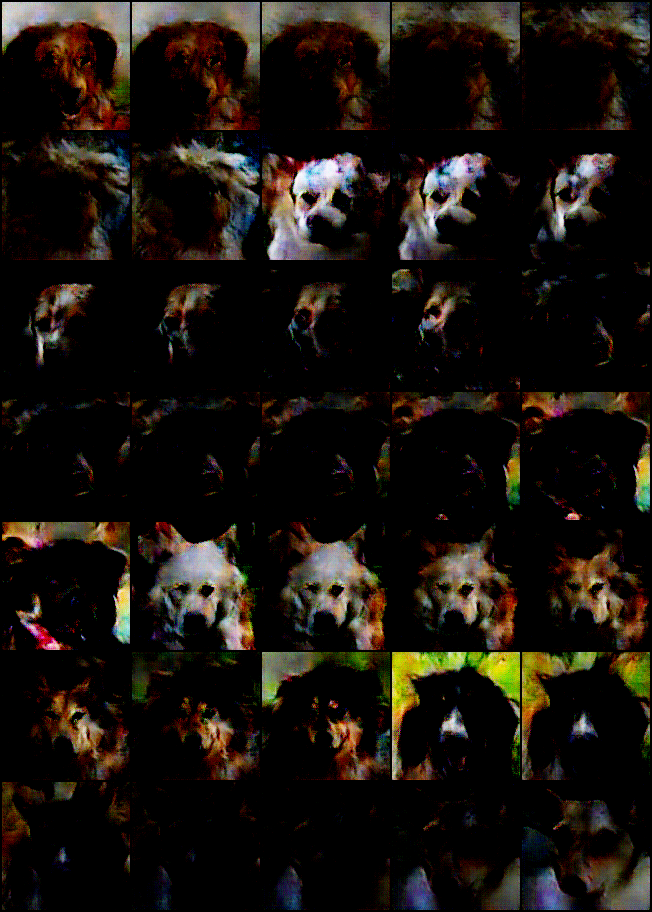

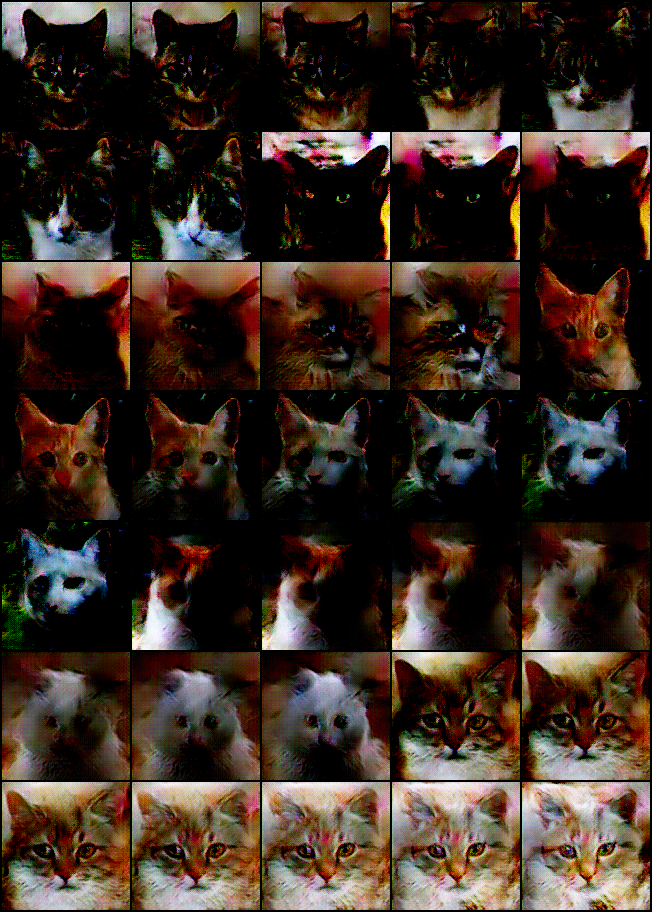

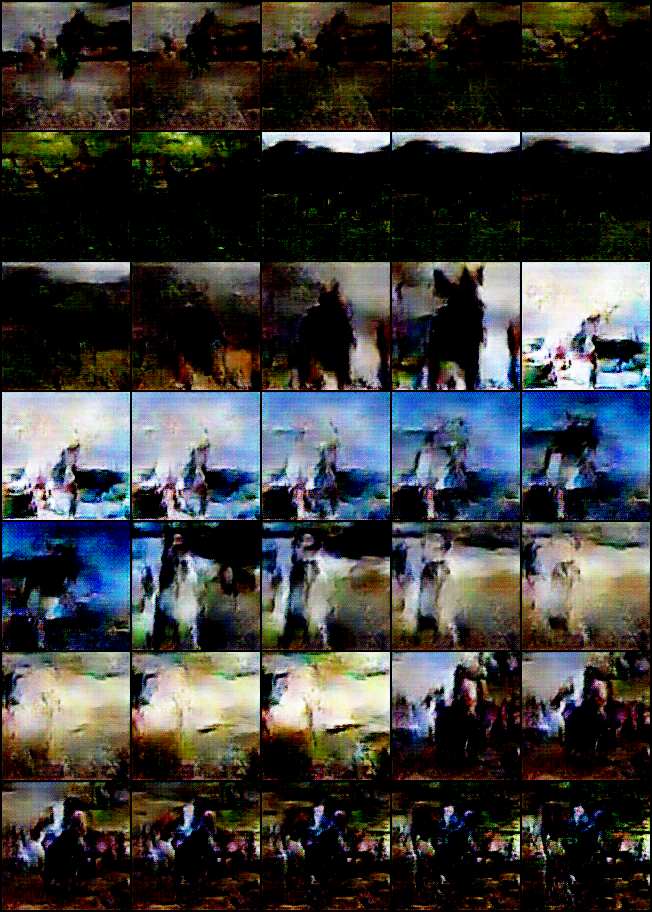

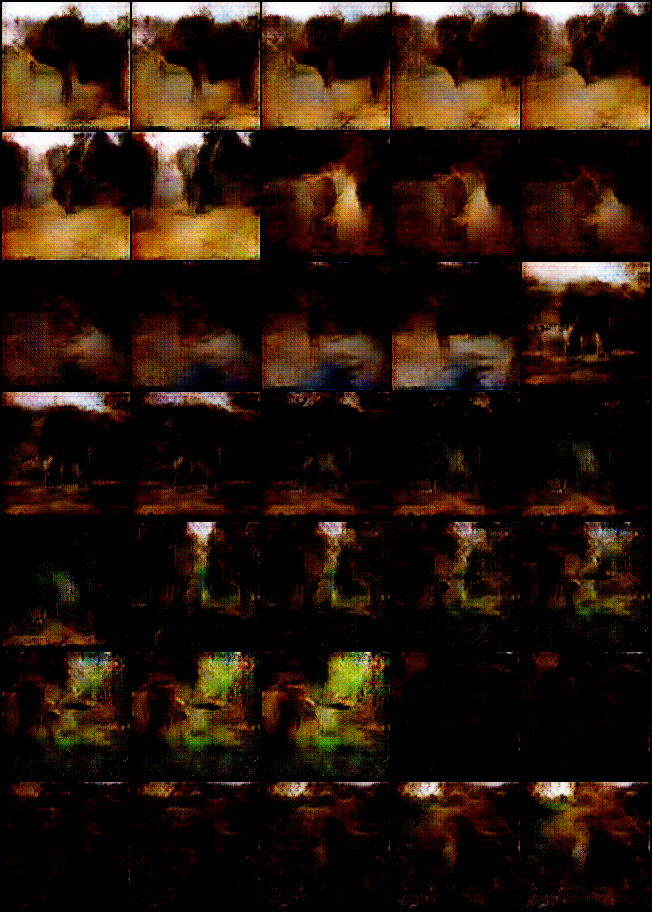

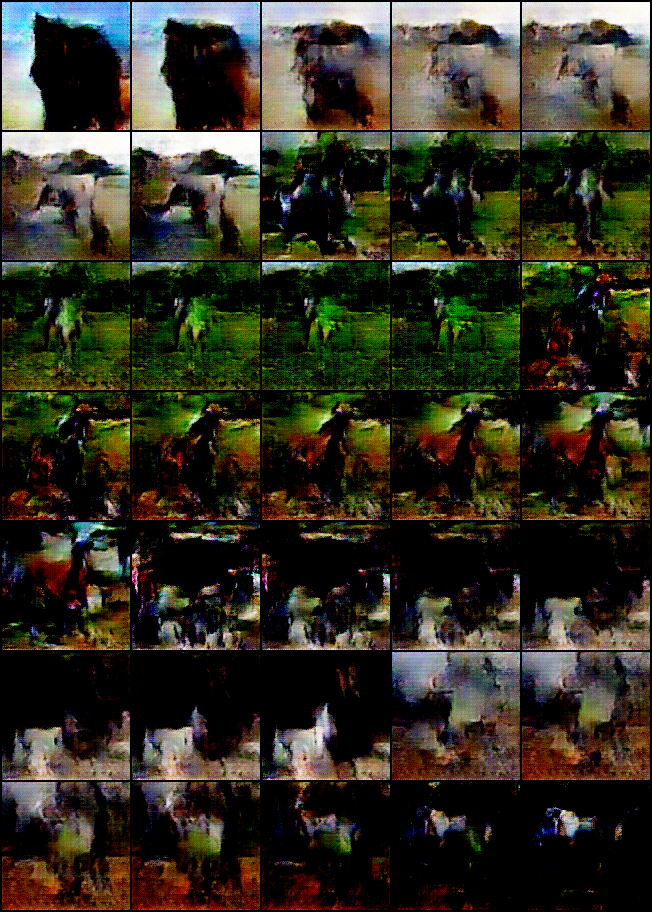

In [23]:
for dataset in datasets_list:
  path = f'models/{dataset}_model.pth'
  trained_model = load_model(path, device)
  latent_img = visualize_latent(trained_model, 5, 5, device)
  save_image(latent_img.cpu(),
              f'./compare.png', nrow=5)
  display(Img(filename='./compare.png'))